Estudo de Regressão Quantílica em commodities - CCMFUT (contrato futuro de milho b3)

Passo 1: Importando as Bibliotecas

In [55]:
#Import libraries

import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf #inicialmente vou usar dados de arquivo com pd.read_excel
import statsmodels.regression.quantile_regression as qreg
import ta
import sklearn.metrics as metrics
get_ipython().run_line_magic("matplotlib", "inline")

Passo 2: Carregar a base de dados

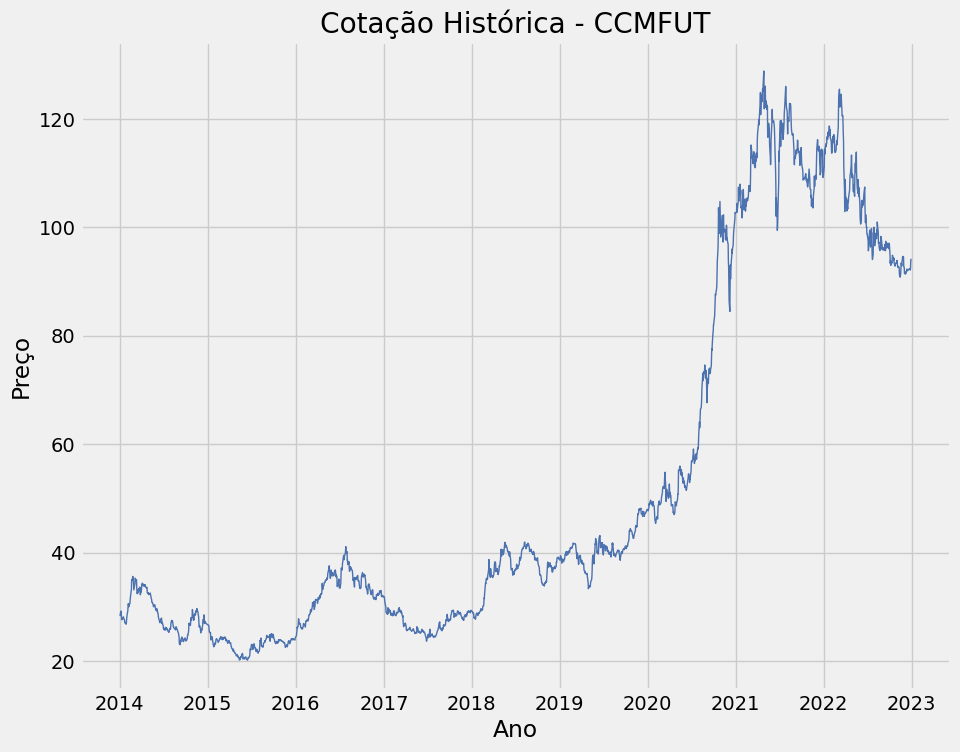

In [56]:
#Carrega a base de dados e faz o checks iniciais

#estilo gráfico dentro do matplotlib
plt.style.use("fivethirtyeight")
#https://matplotlib.org/stable/gallery/style_sheets_reference.html

#Carregando a base a partir de arquivo, renomeando as colunas e setando o index e invertendo para ascending datetime
#no caso de planilha de excel, separadores decimais devem estar com "." e não ","
ticker = "CCMFUT"
df0 = pd.read_excel("CCM_Historico.xlsx", names=["Date", "Open", "High", "Low", "Close"]).set_index("Date")
df0 = df0.replace({',': '.'}, regex=True) #substitui "," por "."

#Janela temporal#
inicio = "01-01-2014"
fim = "01-01-2023"

df1 = df0.loc[inicio:fim].sort_index(ascending=True).astype(float)
#Carregando a base a partir de yf para outros ativos disponíveis
#DF1 = yf.downloader(ticker, "2014-01-01", "2023-01-01")

#Visualização
with plt.style.context("seaborn-deep"):
    plt.figure(figsize = (10,8))
    plt.plot(df1["Close"], linewidth = 1)
    plt.xlabel("Ano")
    plt.ylabel("Preço")
    plt.title("Cotação Histórica - "+ticker)

Passo 3 - Variáveis e Alvo

In [57]:
# Construção dos alvos

periodos = 3    #3 dias

# Alvo 1 - Retorno %
df1["Retorno"] = df1["Close"].pct_change(periodos)
df1["Alvo1"] = df1["Retorno"].shift(-periodos)

# Variação em pontos do alvo
df1["Pontos"] = (df1["Close"] - df1["Close"].shift(1))
df1["Pontos"] = df1["Pontos"].shift(-periodos)

#Criação do alvo categórico
df1["Alvo1_cat"] = np.where(df1["Alvo1"] > 0 , 1, 0)

In [58]:
# Cria uma média móvel e sua distância
df1["mm"] = df1["Close"].rolling(10).mean()
df1["dist_mm"] = round((df1["Close"]/df1["mm"]-1), 3)

# Variáveis de indicadores técnicos - Biblioteca TA

indicator_rsi14 = ta.momentum.RSIIndicator(close = df1["Close"], window = 14)
indicator_rsi2 = ta.momentum.RSIIndicator(close = df1["Close"], window = 2)
indicator_atr14 = ta.volatility.AverageTrueRange(high = df1["High"], low = df1["Low"]
                                                , close = df1["Close"], window = 14)
indicator_bb = ta.volatility.bollinger_wband(close = df1["Close"]
                                            , window = 20, window_dev = 2)

df1["RSI14"] = indicator_rsi14.rsi()
df1["RSI2"] = indicator_rsi2.rsi()    
df1["RSI14_W"] = round(df1["dist_mm"]*df1["RSI14"], 3)  #RSI14 Ponderado pela distância da mm
df1["RSI2_W"] = round(df1["dist_mm"]*df1["RSI2"], 3)    #RSI2 Ponderado oela distaância da mm
df1["abertura_bb"] = indicator_bb
df1["ATR14"] = indicator_atr14.average_true_range()

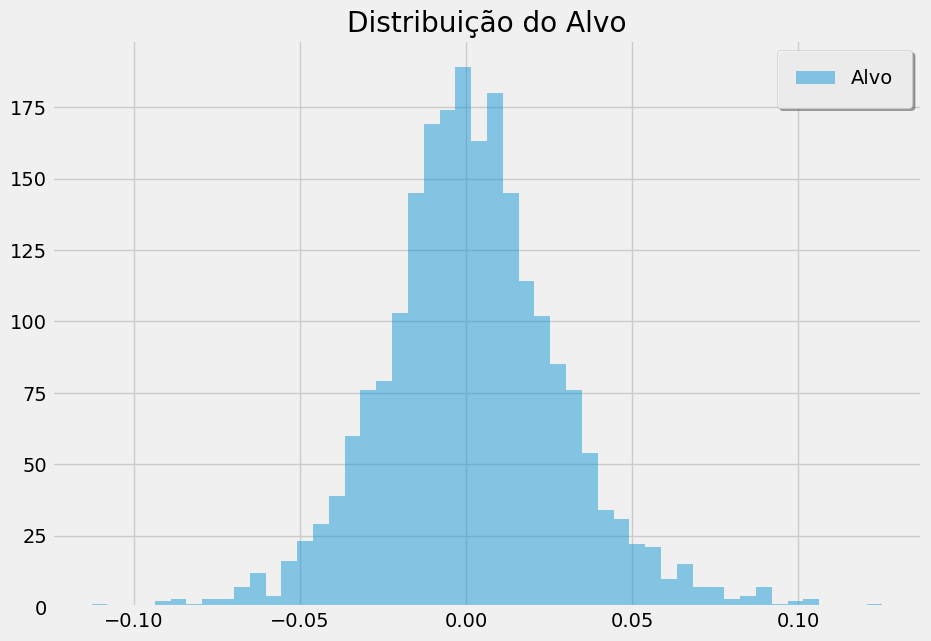

In [59]:
config = dict(histtype = "stepfilled", alpha = 0.45, density = False, bins = 50)

plt.figure(figsize = (10,7))
plt.hist(df1["Alvo1"], **config, label = "Alvo")

#Formatação da legenda - Válida para qualquer tipo de gráfico
plt.legend(loc = "upper right"
           , frameon = True
           , ncol = 2
           , fancybox = True
           , framealpha = 0.95
           , shadow = True
           , borderpad = 1)
plt.title("Distribuição do Alvo");


In [60]:
df1.columns

Index(['Open', 'High', 'Low', 'Close', 'Retorno', 'Alvo1', 'Pontos',
       'Alvo1_cat', 'mm', 'dist_mm', 'RSI14', 'RSI2', 'RSI14_W', 'RSI2_W',
       'abertura_bb', 'ATR14'],
      dtype='object')

In [61]:
# Filtrando os valores missing

df1_filtrado = df1.dropna(axis = 0)

# Separando os dados entre treinamento e teste

# Treinando o modelo de 01-01-2014 a 31-12-2017
start_train = "2012-01-01"
end_train = "2018-12-31"
# Testando o modelo de 01-01-2018 a 31-12-2021
start_test = "2019-01-01"
end_test = "2021-12-31"

df1_train = df1_filtrado.loc[start_train : end_train]

df1_test = df1_filtrado.loc[start_test : end_test]

df1_filtrado.columns[12:16]

# Separando os dados com as variáveis em x e o alvo em y

x_train = df1_train.iloc[:, 12:16]
y_train = df1_train["Alvo1"]

x_test = df1_test.iloc[:, 12:16]
y_test = df1_test["Alvo1"]


In [62]:
df1_filtrado

,Open,High,Low,Close,Retorno,Alvo1,Pontos,Alvo1_cat,mm,dist_mm,RSI14,RSI2,RSI14_W,RSI2_W,abertura_bb,ATR14
Date,,,,,,,,,,,,,,,,
2014-01-29,27.05,27.82,27.02,27.73,0.023625,0.055175,0.78,1,27.364,0.013,49.729220,89.762900,0.646,1.167,9.006168,0.453410
2014-01-30,27.73,28.12,27.52,28.10,0.049291,0.065125,0.67,1,27.360,0.027,55.501390,94.362222,1.499,2.548,8.931708,0.463881
2014-01-31,28.08,28.53,28.01,28.48,0.052476,0.073385,0.64,1,27.422,0.039,60.515734,97.068002,2.360,3.786,8.682144,0.467890
2014-02-03,28.46,29.36,28.38,29.26,0.055175,0.035202,-0.28,1,27.583,0.061,68.389678,99.012885,4.172,6.040,8.768072,0.504469
2014-02-04,29.26,29.93,29.15,29.93,0.065125,0.002673,-0.28,1,27.855,0.074,73.312757,99.538638,5.425,7.366,10.761890,0.524150
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-20,92.22,92.53,91.66,92.18,0.001195,0.001736,0.00,1,91.991,0.002,46.613415,58.846063,0.093,0.118,4.490531,0.947940
2022-12-21,92.18,92.33,91.76,92.29,0.000651,-0.001842,-0.22,0,92.075,0.002,47.920099,83.699766,0.096,0.167,4.234699,0.920944
2022-12-22,92.30,92.41,91.90,92.34,0.001953,0.001624,0.37,1,92.133,0.002,48.536691,89.477057,0.097,0.179,3.684610,0.891591


Passo 4 - Entendendo a Regressão Quantílica

In [63]:
percentis = [0.10, 0.25, 0.50, 0.75, 0.90]

# Função para rodar a regressão ao longo do vetor "quantis"
def reg_q(q):
   mod = qreg.QuantReg(y_train, x_train).fit(q = q)
   coefs = pd.DataFrame()
   coefs["param"] = mod.params
   coefs = pd.concat([coefs, mod.conf_int()], axis = 1) 
   coefs["q"] = q
   coefs.columns = ["beta", "beta_lower", "beta_upper", "percentil"]
    
   return coefs

# Inicializa um DF para armazenar os coeficientes da regressão 

Qreg_coefs = pd.DataFrame()

for q in percentis:
    coefs = reg_q(q)
    Qreg_coefs = pd.concat([Qreg_coefs, coefs])

In [64]:
Qreg_coefs

,beta,beta_lower,beta_upper,percentil
RSI14_W,0.001156,-0.003566,0.005878,0.10
RSI2_W,-0.001064,-0.005267,0.003140,0.10
abertura_bb,-0.000494,-0.001003,0.000015,0.10
ATR14,-0.043040,-0.053282,-0.032797,0.10
RSI14_W,0.000811,-0.002630,0.004252,0.25
RSI2_W,-0.000294,-0.003421,0.002832,0.25
abertura_bb,-0.000373,-0.000759,0.000013,0.25
ATR14,-0.018834,-0.026496,-0.011173,0.25
RSI14_W,0.004143,0.000775,0.007511,0.50
RSI2_W,-0.002271,-0.005261,0.000719,0.50


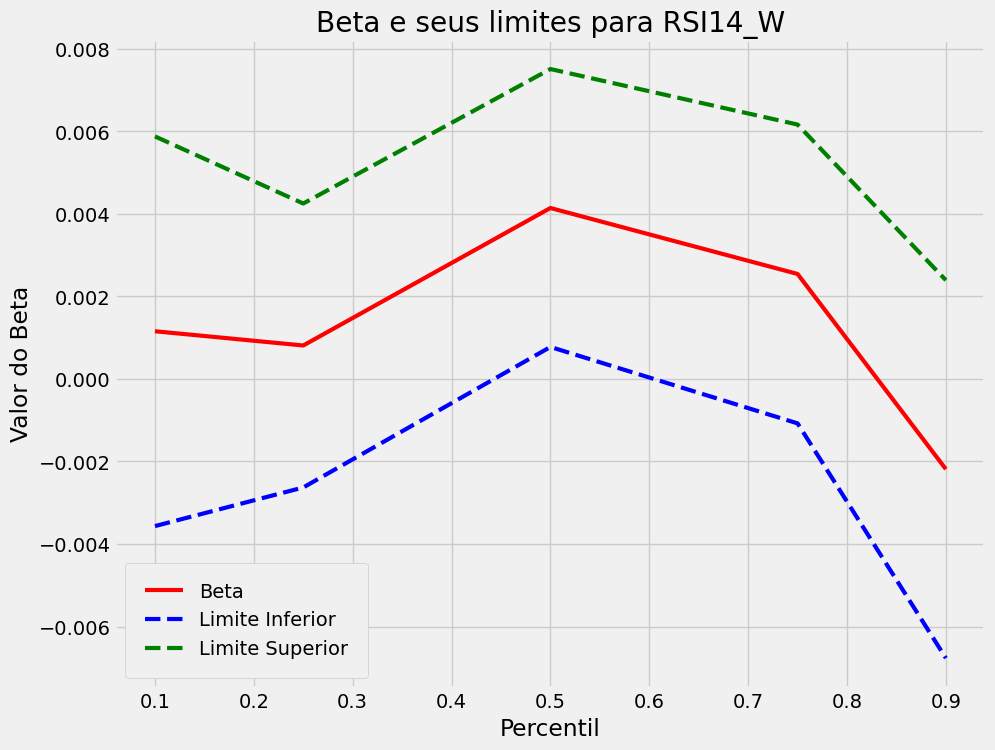

In [65]:
# Gráfico de comparação do beta nos percentis, para o IFR14_W por exemplo

with plt.style.context("seaborn-deep"):
    plt.figure(figsize = (10,8))
    plt.plot(Qreg_coefs.loc[["RSI14_W"]]["percentil"]
            , Qreg_coefs.loc[["RSI14_W"]]["beta"], linewidth = 3, label = "Beta", c = "red")
    plt.plot(Qreg_coefs.loc[["RSI14_W"]]["percentil"]
            , Qreg_coefs.loc[["RSI14_W"]]["beta_lower"], "--", linewidth = 3, label = "Limite Inferior", c = "blue")
    plt.plot(Qreg_coefs.loc[["RSI14_W"]]["percentil"]
            , Qreg_coefs.loc[["RSI14_W"]]["beta_upper"], "--", linewidth = 3, label = "Limite Superior", c = "green")
    plt.xlabel("Percentil")
    plt.ylabel("Valor do Beta")
    plt.legend(loc = "lower left"
               , frameon = True
               , fancybox = True
               , framealpha = 1,
               borderpad = 1)
    plt.title("Beta e seus limites para RSI14_W")
    


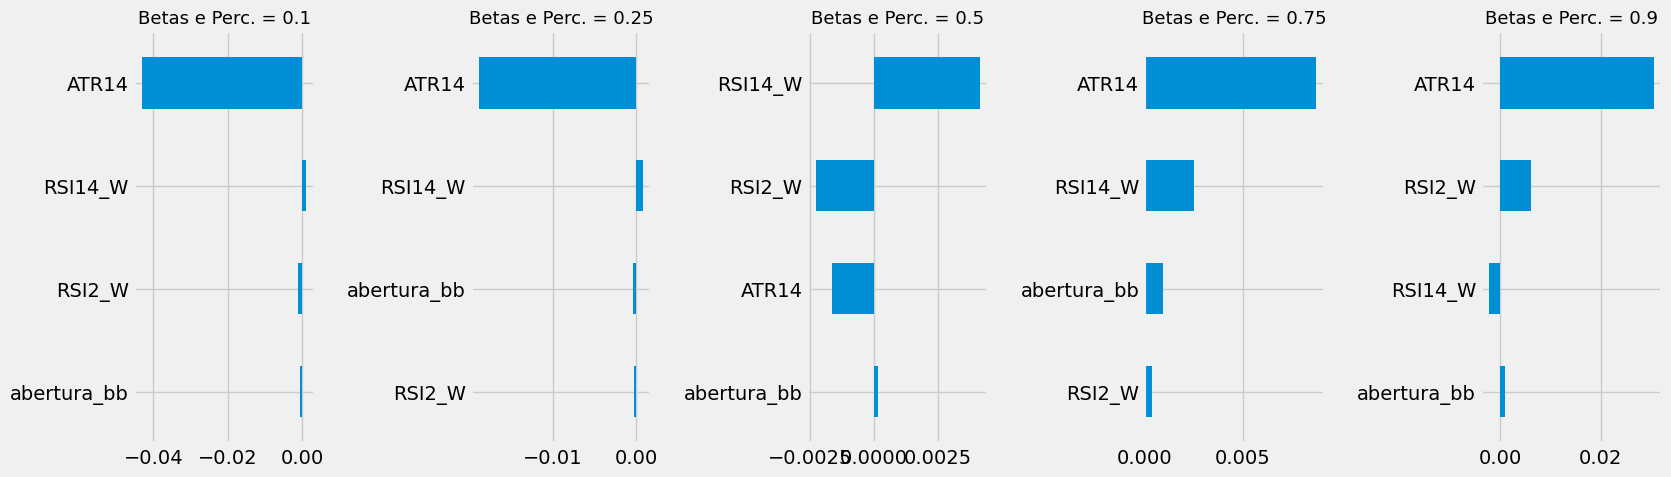

In [66]:
# Comparação dos betas em relação aos diferentes quantis

# preparação para ordenar os betas por magnitude
Qreg_coefs["beta_abs"] = np.abs(Qreg_coefs["beta"])
Qreg_coefs = Qreg_coefs.sort_values(by = ["percentil", "beta_abs"])

#gráfico:
fig = plt.figure(figsize = (17, 5))
n = len(percentis)

for i in range(n):
    plt.subplot(1, n, i+1)
    w = Qreg_coefs[Qreg_coefs["percentil"] == percentis[i]]
    w["beta"].plot.barh()
    plt.title("Betas e Perc. = " + str(percentis[i] ), fontsize = 13)

fig.tight_layout() #evitar que os gráficos se sobrescrevam
plt.show()

In [67]:
# Previsão para toda a base

for q in percentis:
    df1_filtrado.loc[: , "Previsto_" + str(q)] = qreg.QuantReg(y_train, x_train).fit(q = q).predict(df1_filtrado.iloc[:, 12:16])

df1_filtrado.head(20)

,Open,High,Low,Close,Retorno,Alvo1,Pontos,Alvo1_cat,mm,dist_mm,...,RSI2,RSI14_W,RSI2_W,abertura_bb,ATR14,Previsto_0.1,Previsto_0.25,Previsto_0.5,Previsto_0.75,Previsto_0.9
Date,,,,,,,,,,,,,,,,,,,,,
2014-01-29,27.05,27.82,27.02,27.73,0.023625,0.055175,0.78,1,27.364,0.013,...,89.762900,0.646,1.167,9.006168,0.453410,-0.024458,-0.011720,0.000617,0.014538,0.028812
2014-01-30,27.73,28.12,27.52,28.10,0.049291,0.065125,0.67,1,27.360,0.027,...,94.362222,1.499,2.548,8.931708,0.463881,-0.025355,-0.011604,0.000987,0.017269,0.035760
2014-01-31,28.08,28.53,28.01,28.48,0.052476,0.073385,0.64,1,27.422,0.039,...,97.068002,2.360,3.786,8.682144,0.467890,-0.025726,-0.011252,0.001700,0.019742,0.041429
2014-02-03,28.46,29.36,28.38,29.26,0.055175,0.035202,-0.28,1,27.583,0.061,...,99.012885,4.172,6.040,8.768072,0.504469,-0.027645,-0.011166,0.004042,0.025633,0.052657
2014-02-04,29.26,29.93,29.15,29.93,0.065125,0.002673,-0.28,1,27.855,0.074,...,99.538638,5.425,7.366,10.761890,0.524150,-0.029439,-0.011655,0.006483,0.031388,0.060767
2014-02-05,29.87,30.60,29.77,30.57,0.073385,-0.003925,0.44,0,28.209,0.084,...,99.771324,6.468,8.381,13.655901,0.545996,-0.031682,-0.012599,0.008888,0.037355,0.068384
2014-02-06,30.55,30.94,30.24,30.29,0.035202,0.010234,0.15,1,28.529,0.062,...,69.223036,4.482,4.292,15.328070,0.556996,-0.030929,-0.013838,0.010174,0.032377,0.049386
2014-02-07,30.24,30.29,29.41,30.01,0.002673,0.020993,0.04,1,28.821,0.041,...,42.932579,2.781,1.760,16.317682,0.580068,-0.031684,-0.015277,0.008984,0.028194,0.039103
2014-02-10,30.03,30.56,29.87,30.45,-0.003925,0.032841,0.81,1,29.188,0.043,...,73.985016,3.048,3.181,17.616348,0.587920,-0.033866,-0.016111,0.007041,0.030720,0.048892


In [68]:
qreg.QuantReg(y_train, x_train).fit(q = 0.2).params

RSI14_W        0.001283
RSI2_W        -0.000423
abertura_bb   -0.000508
ATR14         -0.023471
dtype: float64

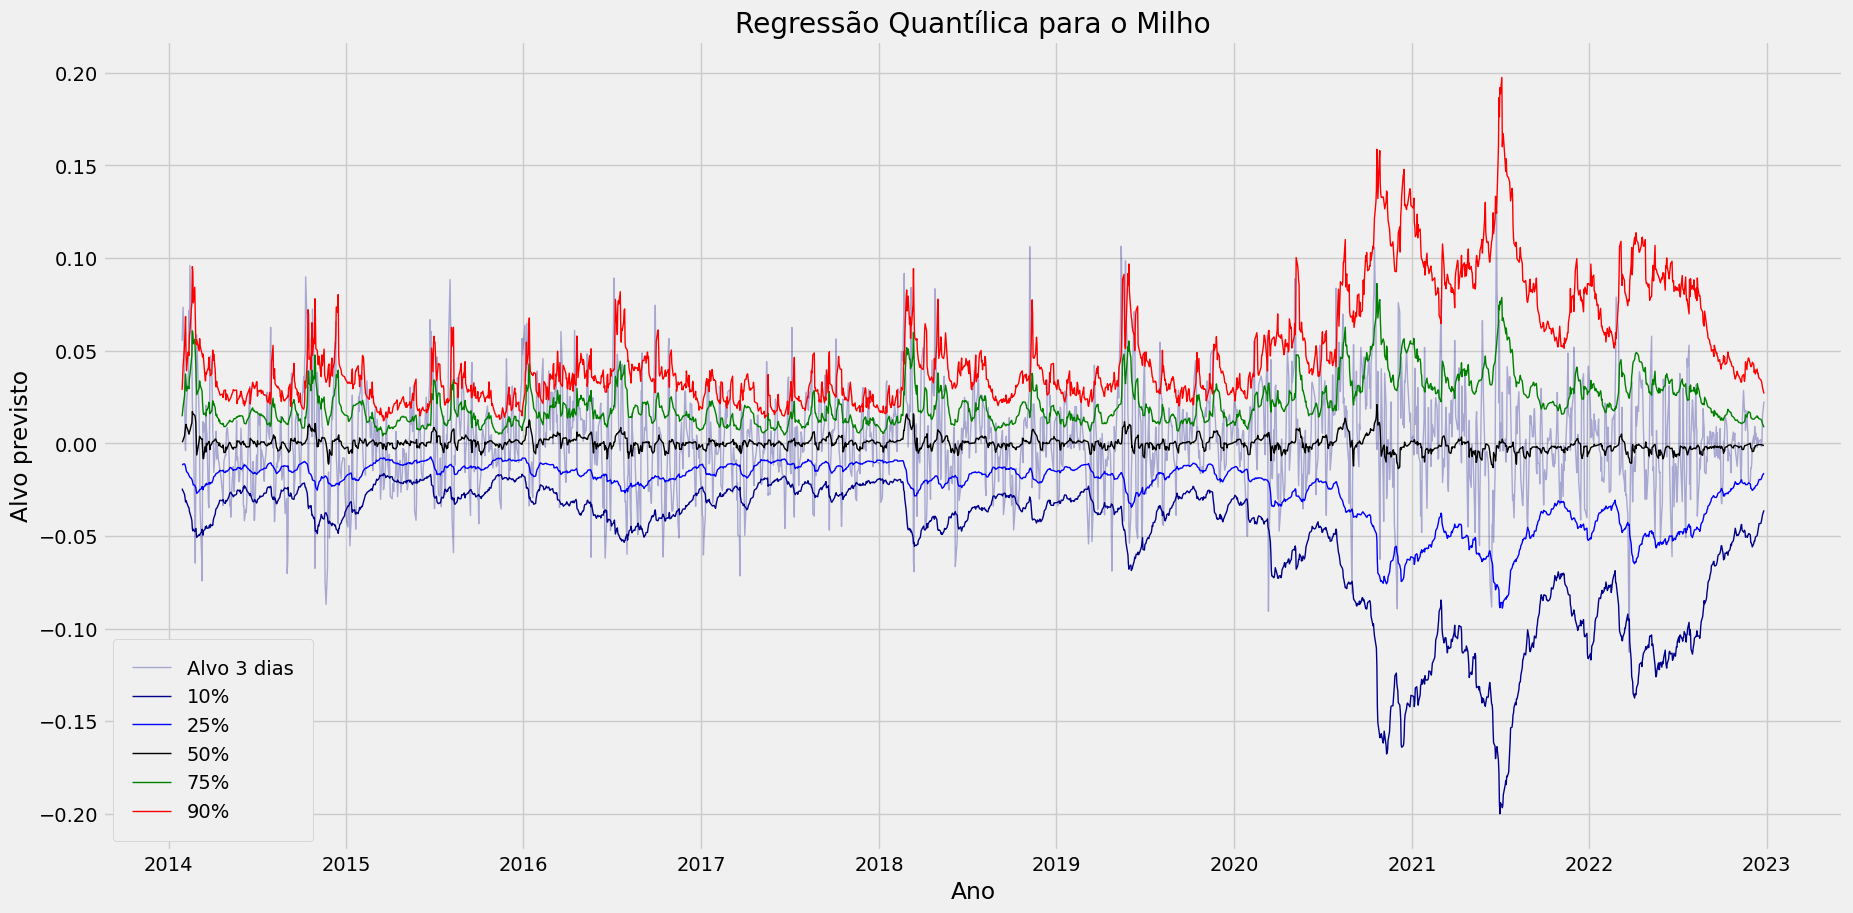

In [69]:
with plt.style.context("seaborn-v0_8-bright"):
    plt.figure(figsize = (20,10))
    plt.plot(df1_filtrado["Alvo1"], linewidth = 1, label = "Alvo 3 dias"
             , c = "darkblue", alpha = 0.3)
    plt.plot(df1_filtrado["Previsto_0.1"], linewidth = 1, label = "10%", c = "darkblue")
    plt.plot(df1_filtrado["Previsto_0.25"], linewidth = 1, label = "25%", c = "blue")
    plt.plot(df1_filtrado["Previsto_0.5"], linewidth = 1, label = "50%", c = "black")
    plt.plot(df1_filtrado["Previsto_0.75"], linewidth = 1, label = "75%", c = "green")
    plt.plot(df1_filtrado["Previsto_0.9"], linewidth = 1, label = "90%", c = "red")
    plt.xlabel("Ano")
    plt.ylabel("Alvo previsto")
    plt.legend(loc = "lower left"
           , frameon = True
           , fancybox = True
           , framealpha = 1
           , borderpad = 1)
    plt.title("Regressão Quantílica para o Milho")

Passo 5 - A regra de trading

In [70]:
# Calculando a performance - para toda a base
custo_op = 0.0001 
#0.01% - R$2 reais em R$20000, assumindo operação completa - C/V

df1_filtrado.loc[:, "Sinal1"] = np.where(df1_filtrado.loc[: , "Previsto_0.1"] > df1_filtrado.loc[: , "Previsto_0.1"].shift(1)
                                           , -1, 1)
df1_filtrado.loc[:, "Sinal2"] = np.where(df1_filtrado.loc[: , "Previsto_0.25"] > df1_filtrado.loc[: , "Previsto_0.25"].shift(1)
                                           , -1, 1)
df1_filtrado.loc[:, "Sinal3"] = np.where(df1_filtrado.loc[: , "Previsto_0.5"] > df1_filtrado.loc[: , "Previsto_0.5"].shift(1)
                                           , -1, 1)
df1_filtrado.loc[:, "Sinal4"] = np.where(df1_filtrado.loc[: , "Previsto_0.75"] > df1_filtrado.loc[: , "Previsto_0.75"].shift(1)
                                           , 1, -1)
df1_filtrado.loc[:, "Sinal5"] = np.where(df1_filtrado.loc[: , "Previsto_0.9"] > df1_filtrado.loc[: , "Previsto_0.9"].shift(1)
                                           , 1, -1)
df1_filtrado.loc[:, "Sinal"] = (df1_filtrado.loc[:, "Sinal1"]
                                + df1_filtrado.loc[:, "Sinal2"]
                                + df1_filtrado.loc[:, "Sinal3"]
                                + df1_filtrado.loc[:, "Sinal4"]
                                + df1_filtrado.loc[:, "Sinal5"])/5

df1_filtrado.loc[: , "Retorno_Modelo"] = np.sign(df1_filtrado.loc[:, "Sinal"])*df1_filtrado["Alvo1"] - custo_op

In [71]:
# Modelo usa os diferentes sinais e "vota" para compra(positivo)/venda(negativo)

In [72]:
df1_filtrado["Sinal"]

Date
2014-01-29    0.2
2014-01-30    0.2
2014-01-31    0.2
2014-02-03    0.2
2014-02-04    0.6
             ... 
2022-12-20   -0.6
2022-12-21   -0.6
2022-12-22   -0.6
2022-12-23   -0.6
2022-12-26   -0.6
Name: Sinal, Length: 2206, dtype: float64

""


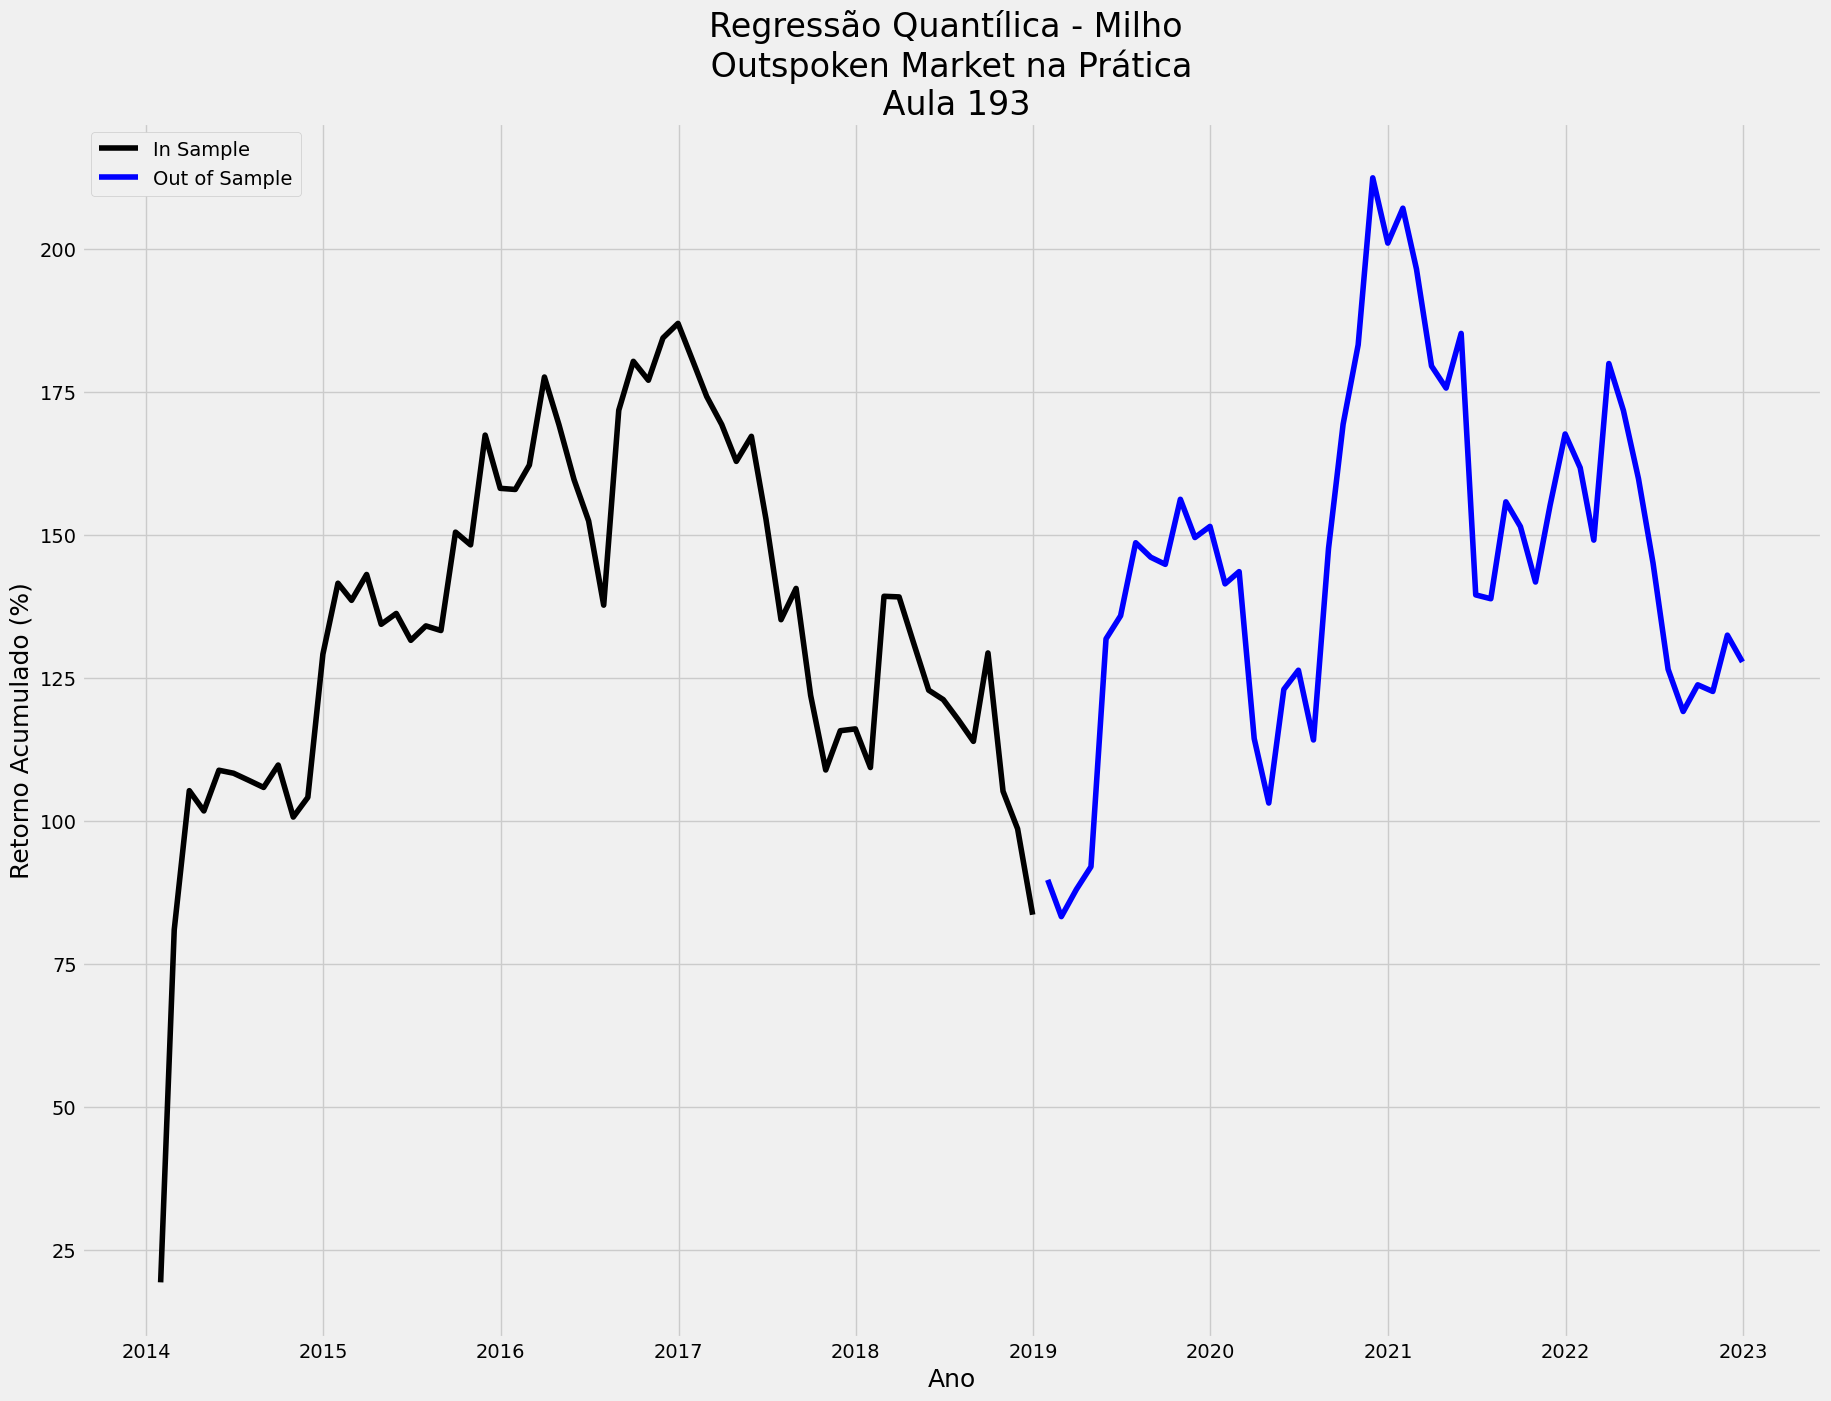

In [73]:
# Gráfico da performance

# Para fazer um conditional plot

df2 = df1_filtrado.copy()

df2.index.name = "Data"
df2.reset_index(inplace = True)

df2["Data"] = pd.to_datetime(df2["Data"])

df2["train_test"] = np.where(df2["Data"] > end_train, 1, -1)

base_agregada = df2.resample("M", on = "Data").sum()

base_agregada.loc[: , "Retorno_Modelo_Acumulado"] = base_agregada["Retorno_Modelo"].cumsum()*100

# Plota o grafico
fig, ax = plt.subplots(figsize = (20, 15))

def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "blue"
    leg = "In Sample" if (group["train_test"] < 0).all() else "Out of Sample"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c = color, linewidth = lw, label = leg)
    plt.xlabel("Ano"
           , fontsize = 18);
    plt.ylabel("Retorno Acumulado (%)"
           , fontsize = 18);
    plt.title("Regressão Quantílica - Milho \n Outspoken Market na Prática \n Aula 193", fontsize = 24)
    plt.legend(loc = "upper left"
           , frameon = True
           , fancybox = True
           , framealpha = 1)

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)